# Learning to Drive in Adverse Weather Conditions

In [192]:
torch.cuda.empty_cache()

## Introduction & Setup

This project is designed to explore using Reinforcement learning to teach an autonomous agent to drive in adverse weather conditions.

### Setup

- The project will be performed using an autonomous drving simulator called CARLA.
- Python 3.8
- Anconda

[Project Github](https://github.com/rbuckley25/Tempestas)

### Image Segmentor

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import carla

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, Subset 
from torch.utils.data import ConcatDataset
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, weather, town, test=False , transform=None, target_transform=None):
        dirt = './Datasets/'+weather+'/'+town
        if test:
            dirt = dirt+'/test'
        
        self.sem_dir = dirt+'/Semantic'
        self.rgb_dir = dirt+'/RGB'
        self.transform = transform
        self.target_transform = target_transform
        self.names = os.listdir(self.rgb_dir)

    def __len__(self):
        return len(os.listdir(self.sem_dir))

    def __getitem__(self, idx): 
        img_path = os.path.join(self.rgb_dir, self.names[idx])
        image = read_image(img_path)
        label_name = self.names[idx].split('.')[0]+'.npy'
        label = np.load(os.path.join(self.sem_dir, label_name))
        label = torch.tensor(label).permute(2,0,1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
class CropResizeTransform:
    def __init__(self, top, left, width, height, size):
        self.top = top
        self.left = left
        self.width = width
        self.height = height
        self.size = size

    def __call__(self, x):
        return TF.resized_crop(x,self.top,self.left,self.width,self.height,self.size)

class Hflip:
    def __init__(self):
        pass

    def __call__(self, x):
        return TF.hflip(x)


In [4]:
class PerceptionNet(nn.Module):

    def __init__(self):
        super(PerceptionNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6a = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        self.conv6b = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        
        self.conv7 = torch.nn.ConvTranspose2d(64,512, kernel_size =4, stride=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.conv8 = torch.nn.ConvTranspose2d(512,256, kernel_size =4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv9 = torch.nn.ConvTranspose2d(256,128, kernel_size =4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.conv10 = torch.nn.ConvTranspose2d(128,64, kernel_size =4, stride=2, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv11 = torch.nn.ConvTranspose2d(64,32, kernel_size =4, stride=2, padding=1)
        self.bn10 = nn.BatchNorm2d(32)
        
        self.conv12 = torch.nn.ConvTranspose2d(32,13, kernel_size =4, stride=2,padding=1)
        
            
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x),negative_slope=0.02)
        x = F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.02)
        return self.conv6a(x)

    
    def decode(self, x):
        x = F.leaky_relu(self.bn6(self.conv7(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn7(self.conv8(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn8(self.conv9(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn9(self.conv10(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn10(self.conv11(x)),negative_slope=0.02)
        return torch.sigmoid(self.conv12(x))

    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        latent_sample = mu + eps*std
        return latent_sample
    
    def forward(self, x):
        x = x.to(device, dtype=torch.float32)
        latent = self.encode(x)
        #latent = self.reparameterize(mu,logvar)
        out = self.decode(latent)
        return out, latent

In [47]:
model = PerceptionNet()
model.to(device)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [6]:
def initalize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer,torch.nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight.data,nonlinearity='relu')

In [48]:
model.apply(initalize_weights)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss(weight=lable_weights)

In [ ]:
def loss_fn(y_batch,pred,mu,logvar):
    cross = nn.BCELoss(reduction='sum')
    rec_loss = cross(y_batch,pred)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec_loss + KLD

Reference: https://github.com/pytorch/examples/blob/master/vae/main.py

In [9]:
crop_transform = CropResizeTransform(64,14,50,100,(128,128))
town03_data = CustomImageDataset('ClearNoon','Town03',test=False)
town03_test_data = CustomImageDataset('ClearNoon','Town03',test=True)
town04_data = CustomImageDataset('ClearNoon','Town04',test=False)
town04_test_data = CustomImageDataset('ClearNoon','Town04',test=True)
town07_data = CustomImageDataset('ClearNoon','Town07',test=False)
#flipped data
town03_data_hf = CustomImageDataset('ClearNoon','Town03',test=False,transform=Hflip(),target_transform=Hflip())
town03_test_data_hf = CustomImageDataset('ClearNoon','Town03',test=True,transform=Hflip(),target_transform=Hflip())
town04_data_hf = CustomImageDataset('ClearNoon','Town04',test=False,transform=Hflip(),target_transform=Hflip())
town04_test_data_hf = CustomImageDataset('ClearNoon','Town04',test=True,transform=Hflip(),target_transform=Hflip())
town07_data_hf = CustomImageDataset('ClearNoon','Town07',test=False,transform=Hflip(),target_transform=Hflip())

train_data = ConcatDataset([town03_data,town04_data,town07_data,town03_data_hf,town04_data_hf,town07_data_hf])
test_data = ConcatDataset([town03_test_data,town04_test_data,town03_test_data_hf,town04_test_data_hf])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

In [ ]:
next(iter(train_loader))

In [ ]:
#generate label frequency for loss weigthing
label_freq_weights = np.zeros(13)
count = 0
for index, image in enumerate(train_data):
    if index % 100 == 0:
        im = recode_tags(image[1],recode_dict)
        values, counts = np.unique(im,return_counts=True)
        label_freq_weights[values] += counts

In [ ]:
label_freq_weights_4 = np.array([1121034.,  530218.,  116395.,  193273.,   23201.,   83135.,
        258966., 6886841.,  121457.,  777388.,   23087.,  230427.,
         71186.])

In [43]:
label_freq_weights_3 = np.array([ 426548.,  103471.,   59734.,   61954.,    3507.,   17818.,
         40000., 2355300.,   28709.,  355806.,    4624.,   49085.,
         21033.])

In [ ]:
67739

In [ ]:
label_freq_weights_2 = np.array([2198123.,  321519.,   74114.,  139571.,    9590.,   49337.,
         94720., 1339440.,   78098.,  407971., 1242280.,  132659.,
         40194.])

In [ ]:
label_freq_weights_1 = np.array([  44733.,  115794.,  302399.,  278934.,   55560.,   64991.,
        435785., 6489878.,  461536.,  765703., 4474860.,  176931.,
         46304.])

In [44]:
clean_lables = np.where(label_freq_weights_3 < 10000, 15000, label_freq_weights_3)

inverse_lables = 1/clean_lables
normalized_lables = inverse_lables/sum(inverse_lables)
lable_weights = torch.tensor(normalized_lables,dtype=torch.float32).to(device)

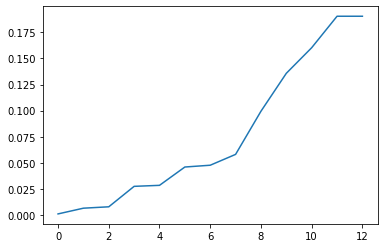

In [190]:
plt.plot(np.sort(normalized_lables))

In [ ]:
#need to caculate an individual weight for each sample for BCELoss
def calculate_weights(im_batch):
    weights = torch.empty(13)
    counts = torch.bincount(im_batch[i].reshape(128*128),minlength=13).numpy()
    counts = np.where(counts < 1, 1, counts)
    weights = torch.tensor((1/counts)/sum(1/counts))
    return weights


In [49]:
def train(epoch,recode_dict):
    global step
    model.train()
    writer = SummaryWriter()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        rgb = data[0]
        target = data[1]
        target = recode_tags(target,recode_dict)
        batch_size = target.shape[0]
        #preds = F.one_hot(preds.to(torch.int64))
        target = target.reshape(batch_size,128,128)
        target = target.to(device,dtype=torch.long)
        optimizer.zero_grad()
        #dont need latent space output while training
        y_batch,_ = model(rgb)
        loss = loss_fn(y_batch,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_size * batch_idx, len(train_loader.dataset),
            100. * batch_idx / len(train_loader),
            loss.item() / len(data)))

        writer.add_scalar("AE Loss", loss.item() / len(data[0]),step)
        step += 1

    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.8f}'.format(
          epoch, avg_loss))
    writer.flush()
    return avg_loss
    
    


def test(epoch,recode_dict):
    model.eval()
    writer = SummaryWriter()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            rgb = data[0]
            target = data[1]
            batch_size = target.shape[0]
            target = recode_tags(target,recode_dict)
            #preds = F.one_hot(preds.to(torch.int64))
            target = target.permute(0,3,1,2)
            target= target.reshape(batch_size,128,128)
            target = target.to(device,dtype=torch.long)
            y_batch,_ = model(rgb)
            test_loss += loss_fn(y_batch,target).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.8f}'.format(test_loss))
    writer.add_scalar("AE test Loss", test_loss,epoch)
    writer.flush()
    writer.close()


for epoch in range(1, 8 + 1):
    step = 0
    smallest_loss = 1000
    
    avg_loss = train(epoch,recode_dict)
    if avg_loss < smallest_loss:
        torch.save(model.state_dict(), './AE_params/model_48.best')
    test(epoch,recode_dict)
    torch.save(model.state_dict(), './AE_params/model_48.final')
   

Train Epoch: 1 [0/70488 (0%)]	Loss: 1.284768
Train Epoch: 1 [512/70488 (1%)]	Loss: 1.284189
Train Epoch: 1 [1024/70488 (1%)]	Loss: 1.283840
Train Epoch: 1 [1536/70488 (2%)]	Loss: 1.284064
Train Epoch: 1 [2048/70488 (3%)]	Loss: 1.284375
Train Epoch: 1 [2560/70488 (4%)]	Loss: 1.284043
Train Epoch: 1 [3072/70488 (4%)]	Loss: 1.284042
Train Epoch: 1 [3584/70488 (5%)]	Loss: 1.284260
Train Epoch: 1 [4096/70488 (6%)]	Loss: 1.284174
Train Epoch: 1 [4608/70488 (7%)]	Loss: 1.284216
Train Epoch: 1 [5120/70488 (7%)]	Loss: 1.283955
Train Epoch: 1 [5632/70488 (8%)]	Loss: 1.282320
Train Epoch: 1 [6144/70488 (9%)]	Loss: 1.283786
Train Epoch: 1 [6656/70488 (9%)]	Loss: 1.282474
Train Epoch: 1 [7168/70488 (10%)]	Loss: 1.283804
Train Epoch: 1 [7680/70488 (11%)]	Loss: 1.283552
Train Epoch: 1 [8192/70488 (12%)]	Loss: 1.283366
Train Epoch: 1 [8704/70488 (12%)]	Loss: 1.284470
Train Epoch: 1 [9216/70488 (13%)]	Loss: 1.283520
Train Epoch: 1 [9728/70488 (14%)]	Loss: 1.284803
Train Epoch: 1 [10240/70488 (14%)]	Los

In [14]:
recode_dict = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9,
    10:10,
    11:11,
    12:12,
    13:0,
    14:3,
    15:1,
    16:3,
    17:2,
    18:5,
    19:3,
    20:4,
    21:3,
    22:9,
}

In [15]:
def recode_tags(sem_image,recode_dict):
    for value in recode_dict.keys():
        sem_image[sem_image==value] = recode_dict[value]
    
    return sem_image

In [60]:
model.load_state_dict(torch.load('./AE_params/model_46.best'))
model.eval()

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

54563
torch.Size([1, 128, 128])


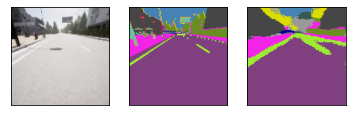

In [74]:
num = random.randint(1,60000)
print(num)
data = train_data.__getitem__(num)
imgs = []
org = data[0]
sem = replace(data[1].numpy().transpose(1,2,0))
imgs.append(Image.fromarray(org.numpy().transpose(1,2,0)))
imgs.append(Image.fromarray(sem))
imgs.append(generate_semantic_im(data[0]))
fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
for i, img in enumerate(imgs):
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [20]:
tag_convert_dict = {0:[70,130,180],
                   1:[70,70,70],
                   2:[100,40,40],
                   3:[55,90,80],
                   4:[220,20,60],
                   5:[153,153,153],
                   6:[157,234,50],
                   7:[128,64,128],
                   8:[244,35,232],
                   9:[107,142,35],
                   10:[0,0,142],
                   11:[102,102,156],
                   12:[220,220,0],
                   13:[70,130,180],
                   14:[81,0,81],
                   15:[150,100,100],
                   16:[230,150,140],
                   17:[180,165,180],
                   18:[250,170,30],
                   19:[110,190,160],
                   20:[170,120,50],
                   21:[45,60,150],
                   22:[145,170,100],
                  }

In [19]:
def generate_semantic_im(RGB_image):
    new_obs = RGB_image.reshape(1,3,128,128)
    out,_ = model(new_obs)
    sample = out.cpu().argmax(dim=1)
    print(sample.shape)
    pic = replace(sample.numpy())
    return Image.fromarray(pic,'RGB')

In [18]:
def replace(a):
    a = a.reshape(128,128)
    pic = np.zeros((128,128,3),dtype='uint8')
    for x, y in np.ndindex(a.shape):
        value = a[x,y]
        RGB_values = tag_convert_dict[value]
        pic[x,y,0] = RGB_values[0]
        pic[x,y,1] = RGB_values[1]
        pic[x,y,2] = RGB_values[2]
    return pic

In [ ]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
    num = random.randint(0,6000)
    data = town03_data.__getitem__(num)
    imgs = []
    org = data[0]
    org = TF.resized_crop(org,64,14,50,100,(128,128))
    sem = TF.resized_crop(torch.tensor(data[1]).permute(2,0,1),64,14,50,100,(128,128))
    
    sem = replace(data[1])


    imgs.append(Image.fromarray(org.numpy().transpose(1,2,0)))
    imgs.append(Image.fromarray(sem.reshape(128,128,3)))
    imgs.append(generate_semantic_im(org))
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])